<h1>Progress Report 2 Notebook</h1>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import json
import sklearn
import lzma
from pandas.io.json import json_normalize

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC

<a id="tablecontent"></a>
<h2>Table of Contents</h2>
<ol>
    <li><a href="#dataacq">Data Acquisition</a></li>
    <li><a href="#dataclean">Data Cleanup</a></li>
    <li><a href="#saving">Saving the Data</a></li>
    <li><a href="#stats">Basic Statistics</a></li>
    <li><a href="#machinelearn">Machine Learning</a></li>
    <li><a href="#conc">Conclusion and Publishing</a></li>
</ol>

<a id="dataacq"></a>
<h2>Data Acquisition [<a href="#tablecontent">TOC</a>]</h2>
<p>First order of buisiness. I had to stick with the really slow procedure since I changed the corpus size close to the deadline. However, this smaller corpus means I can load all of it into memory at once (We're down to only about 3GB uncompressed). First, we acquire the data...</p>

In [2]:
file = open("../data/RC_2017-12-21")

In [3]:
redditframe = pd.read_json(file, lines=True)

In [4]:
file.close()

In [5]:
redditframe.head()

,author,author_cakeday,author_flair_css_class,author_flair_text,body,can_gild,controversiality,created_utc,distinguished,edited,...,is_submitter,link_id,parent_id,permalink,retrieved_on,score,stickied,subreddit,subreddit_id,subreddit_type
0,StrayYoshi,NaN,asc-hierophant,Hierophant,Have to kill him in 1 portal is the way I do i...,True,0,1513814400,None,0,...,False,t3_7l0zv1,t3_7l0zv1,/r/pathofexile/comments/7l0zv1/ggg_please_fix_...,1514928812,1,False,pathofexile,t5_2sf6m,public
1,[deleted],NaN,None,None,[deleted],True,0,1513814400,None,0,...,False,t3_7l4xdt,t3_7l4xdt,/r/The_Donald/comments/7l4xdt/wells_fargo_rais...,1514928812,1,False,The_Donald,t5_38unr,public
2,vgeh,NaN,None,None,3 season- Mostly thrunite ti3. \n\n\n3 season ...,True,0,1513814400,None,0,...,False,t3_7klrjl,t1_drjkcuz,/r/Ultralight/comments/7klrjl/rultralight_disc...,1514928812,3,False,Ultralight,t5_2s7p2,public
3,Litbus_TJ,NaN,None,None,"Beautiful, isn't it?",True,0,1513814400,None,0,...,False,t3_7l3jhf,t1_drjnyvi,/r/hoi4/comments/7l3jhf/isp_face_reveal/drjocb6/,1514928812,15,False,hoi4,t5_2zvvb,public
4,[deleted],NaN,None,None,[deleted],True,0,1513814400,None,0,...,False,t3_7l514t,t3_7l514t,/r/baseball/comments/7l514t/your_opinion_on_th...,1514928812,1,False,baseball,t5_2qm7u,public


In [6]:
len(redditframe)

2929215

<p>Yay! We have the data! And I don't need to save it in it's raw form since loading it doesn't take that long! Looking at the length of the dataframe, we have almost 3 million comments to work with. I probably won't use all of them due to using only some subreddits. Moving on, data Cleanup!</p>

<a id="dataclean"></a>
<h2>Data Cleanup! [<a href="#tablecontent">TOC</a>]</h2>
<p>So, like in the last progress report, I will need to cleanup the data presented in this dataframe. I imagine most of this will be really similar. However, I will only drop columns that seem useless. Any remote interest I will hold onto. Buckle up, I imagine this section will be large like the last one. First, I will start with the columns that seemed to hold no value from the last project phase...</p>

In [7]:
redditframe.columns

Index(['author', 'author_cakeday', 'author_flair_css_class',
       'author_flair_text', 'body', 'can_gild', 'controversiality',
       'created_utc', 'distinguished', 'edited', 'gilded', 'id',
       'is_submitter', 'link_id', 'parent_id', 'permalink', 'retrieved_on',
       'score', 'stickied', 'subreddit', 'subreddit_id', 'subreddit_type'],
      dtype='object')

In [8]:
redditframe.author_flair_css_class.value_counts()

                                                            99919
noflair                                                      8876
default                                                      7468
noob                                                         4767
flair-default                                                4730
MURICA                                                       4415
MAL                                                          3779
new                                                          3557
training                                                     3413
35Gold WW                                                    3396
blue                                                         3263
xbox                                                         2869
mod                                                          2832
Lakers1                                                      2489
34Gold WW                                                    2445
patriots  

<p>Huh... This column actually has interesting values now. I guess AskReddit doesn't use flairs that much (I do pop on the subreddit from time to time, but not enough to make that deduction). I actually want to keep this one for experimentation now that I know what it looks like. Will have to fill in the NaN's though. I will use "none" to indicate NaN, with the lowercase n to indicate it's not the None data type.</p>

In [9]:
redditframe.author_flair_css_class.fillna("none", inplace=True)

In [10]:
redditframe.author_flair_css_class.head()

0    asc-hierophant
1              none
2              none
3              none
4              none
Name: author_flair_css_class, dtype: object

<p>Now that I think about it, The above is just css class. The next one is the actual text of the flair. This might be more meaningful...</p>

In [11]:
redditframe.author_flair_text.value_counts()

                                                                   155963
Text                                                                 4754
New User                                                             4553
Lakers                                                               3181
16                                                                   2646
Patriots                                                             2396
USA                                                                  1896
MAGA                                                                 1836
Rockets                                                              1778
1776                                                                 1739
redditor for 3 months                                                1737
KEK                                                                  1707
Raptors                                                              1579
                                      

In [12]:
redditframe.author_flair_text.fillna("none", inplace=True)

<p>This... might not be as useful.... I'll hold onto it if I can make sense of it later. I don't see moderator here though, I might have to dig for that. The only reason I wanted to keep these flairs was to see if tracking moderator posts would impact things at all or not...</p>
<p>Moving on... Let's see if Controversiality is any different</p>

In [13]:
redditframe.controversiality.value_counts()

0    2863897
1      65318
Name: controversiality, dtype: int64

<p>Still Just a boolean value. I'll keep it for now incase one of my chosen subreddits has a high controversiality rate, but if not, I'll just toss it out like the other columns. Onto the next!</p>

In [14]:
redditframe.created_utc.value_counts()

1513828021    125
1513828025    113
1513828023    113
1513828020    111
1513836363    102
1513836362    100
1513828029     95
1513828024     94
1513836361     94
1513828027     93
1513828028     91
1513828022     88
1513828026     86
1513828032     85
1513891446     83
1513865632     82
1513865633     82
1513865634     82
1513892213     81
1513836364     79
1513875581     79
1513828031     78
1513863707     77
1513865631     76
1513863706     74
1513893797     73
1513828019     72
1513866065     72
1513881638     72
1513828033     71
             ... 
1513854987      5
1513847782      5
1513836350      5
1513850315      5
1513836334      4
1513846621      4
1513838266      4
1513834286      3
1513838267      3
1513836332      3
1513836331      2
1513827987      2
1513855326      2
1513846620      2
1513827980      2
1513854986      2
1513836327      1
1513836337      1
1513855323      1
1513855331      1
1513827981      1
1513855337      1
1513827996      1
1513855336      1
1513836346

<p>And this is not really all that useful. I understand that this is tracking time in some manner if I'm interpreting, but due to the small time window of the corpus, I don't think time created is important anymore. Time of day upvote/downvote analysis is not the focus of this project anyways.</p>

In [15]:
redditframe.drop(["created_utc"], axis=1, inplace=True)

In [16]:
redditframe.head()

,author,author_cakeday,author_flair_css_class,author_flair_text,body,can_gild,controversiality,distinguished,edited,gilded,...,is_submitter,link_id,parent_id,permalink,retrieved_on,score,stickied,subreddit,subreddit_id,subreddit_type
0,StrayYoshi,NaN,asc-hierophant,Hierophant,Have to kill him in 1 portal is the way I do i...,True,0,None,0,0,...,False,t3_7l0zv1,t3_7l0zv1,/r/pathofexile/comments/7l0zv1/ggg_please_fix_...,1514928812,1,False,pathofexile,t5_2sf6m,public
1,[deleted],NaN,none,none,[deleted],True,0,None,0,0,...,False,t3_7l4xdt,t3_7l4xdt,/r/The_Donald/comments/7l4xdt/wells_fargo_rais...,1514928812,1,False,The_Donald,t5_38unr,public
2,vgeh,NaN,none,none,3 season- Mostly thrunite ti3. \n\n\n3 season ...,True,0,None,0,0,...,False,t3_7klrjl,t1_drjkcuz,/r/Ultralight/comments/7klrjl/rultralight_disc...,1514928812,3,False,Ultralight,t5_2s7p2,public
3,Litbus_TJ,NaN,none,none,"Beautiful, isn't it?",True,0,None,0,0,...,False,t3_7l3jhf,t1_drjnyvi,/r/hoi4/comments/7l3jhf/isp_face_reveal/drjocb6/,1514928812,15,False,hoi4,t5_2zvvb,public
4,[deleted],NaN,none,none,[deleted],True,0,None,0,0,...,False,t3_7l514t,t3_7l514t,/r/baseball/comments/7l514t/your_opinion_on_th...,1514928812,1,False,baseball,t5_2qm7u,public


<p>Now we shall look at edited...</p>

In [17]:
redditframe.edited.value_counts()

0             2842107
1514267147          8
1513869367          7
1513899613          7
1513894653          7
1513880394          7
1513878120          7
1513892592          7
1513891233          7
1513884135          7
1513882149          6
1513884745          6
1513873448          6
1513893396          6
1513893572          6
1513880075          6
1513823491          6
1513878356          6
1513873099          6
1513885638          6
1513887392          6
1513891120          6
1513897057          6
1513875720          6
1513882105          6
1513899607          6
1513892355          6
1513877010          6
1513890951          6
1513835839          6
               ...   
1513837474          1
1513833376          1
1514001266          1
1513894734          1
1513892685          1
1513890636          1
1513886539          1
1513890637          1
1513966432          1
1514003314          1
1513896781          1
1513882442          1
1513888585          1
1513886536          1
1513911108

<p>This doesn't seem useful at all, and I had no use for it prior to investigating this. Dropping this column...</p>

In [18]:
redditframe.drop(["edited"], axis=1, inplace=True)

<p>Next, I shall consult the distinguished column.</p>

In [19]:
redditframe.distinguished.value_counts()

moderator    38249
admin           23
Name: distinguished, dtype: int64

<p>Hmmmm, this indicates mods and admins a lot better than the flairs, but this is the only thing it tracks. I'll keep it nonetheless. Fillna, then move onto the next column!</p>

In [20]:
redditframe.distinguished.fillna("none", inplace=True)

In [21]:
redditframe.head()

,author,author_cakeday,author_flair_css_class,author_flair_text,body,can_gild,controversiality,distinguished,gilded,id,is_submitter,link_id,parent_id,permalink,retrieved_on,score,stickied,subreddit,subreddit_id,subreddit_type
0,StrayYoshi,NaN,asc-hierophant,Hierophant,Have to kill him in 1 portal is the way I do i...,True,0,none,0,drjocb3,False,t3_7l0zv1,t3_7l0zv1,/r/pathofexile/comments/7l0zv1/ggg_please_fix_...,1514928812,1,False,pathofexile,t5_2sf6m,public
1,[deleted],NaN,none,none,[deleted],True,0,none,0,drjocb4,False,t3_7l4xdt,t3_7l4xdt,/r/The_Donald/comments/7l4xdt/wells_fargo_rais...,1514928812,1,False,The_Donald,t5_38unr,public
2,vgeh,NaN,none,none,3 season- Mostly thrunite ti3. \n\n\n3 season ...,True,0,none,0,drjocb5,False,t3_7klrjl,t1_drjkcuz,/r/Ultralight/comments/7klrjl/rultralight_disc...,1514928812,3,False,Ultralight,t5_2s7p2,public
3,Litbus_TJ,NaN,none,none,"Beautiful, isn't it?",True,0,none,0,drjocb6,False,t3_7l3jhf,t1_drjnyvi,/r/hoi4/comments/7l3jhf/isp_face_reveal/drjocb6/,1514928812,15,False,hoi4,t5_2zvvb,public
4,[deleted],NaN,none,none,[deleted],True,0,none,0,drjocb7,False,t3_7l514t,t3_7l514t,/r/baseball/comments/7l514t/your_opinion_on_th...,1514928812,1,False,baseball,t5_2qm7u,public


In [22]:
redditframe.retrieved_on.value_counts()

1514932006    200
1514936773    200
1514953963    200
1514930371    200
1514939322    200
1514935247    200
1514936717    200
1514937338    200
1514928973    200
1514937749    200
1514934945    200
1514932716    200
1514952615    200
1514942486    200
1514938322    200
1514940989    200
1514940749    200
1514939485    200
1514936918    200
1514954035    200
1514944564    200
1514940229    200
1514935598    200
1514936348    200
1514953890    200
1514952526    200
1514940939    200
1514932072    200
1514942212    200
1514952887    200
             ... 
1514949299      2
1514944480      2
1514956842      2
1514959227      2
1514946986      2
1514944257      2
1514963159      2
1514954897      2
1514951203      2
1514937828      2
1514931018      2
1514932054      1
1514946260      1
1514931653      1
1514964725      1
1514956018      1
1514928920      1
1514959451      1
1514955759      1
1514960212      1
1514949206      1
1514956921      1
1514958659      1
1514950097      1
1514959365

<p>Another column that I don't really have that much use for. Drop and Move On!</p>

In [23]:
redditframe.drop(["retrieved_on"], axis=1, inplace=True)

In [24]:
redditframe.subreddit_type.value_counts()

public        2907025
restricted      20640
user             1550
Name: subreddit_type, dtype: int64

<p>I might use this for a small linguistic analysis on upvote count, but not for machine learning I imagine. Two things remain. First, I have to fix the cake day column because I do want to play around with that column for analysis. Another would be removing comments that are deleted since I don't think they are of any use.</p>

In [25]:
redditframe.head()

,author,author_cakeday,author_flair_css_class,author_flair_text,body,can_gild,controversiality,distinguished,gilded,id,is_submitter,link_id,parent_id,permalink,score,stickied,subreddit,subreddit_id,subreddit_type
0,StrayYoshi,NaN,asc-hierophant,Hierophant,Have to kill him in 1 portal is the way I do i...,True,0,none,0,drjocb3,False,t3_7l0zv1,t3_7l0zv1,/r/pathofexile/comments/7l0zv1/ggg_please_fix_...,1,False,pathofexile,t5_2sf6m,public
1,[deleted],NaN,none,none,[deleted],True,0,none,0,drjocb4,False,t3_7l4xdt,t3_7l4xdt,/r/The_Donald/comments/7l4xdt/wells_fargo_rais...,1,False,The_Donald,t5_38unr,public
2,vgeh,NaN,none,none,3 season- Mostly thrunite ti3. \n\n\n3 season ...,True,0,none,0,drjocb5,False,t3_7klrjl,t1_drjkcuz,/r/Ultralight/comments/7klrjl/rultralight_disc...,3,False,Ultralight,t5_2s7p2,public
3,Litbus_TJ,NaN,none,none,"Beautiful, isn't it?",True,0,none,0,drjocb6,False,t3_7l3jhf,t1_drjnyvi,/r/hoi4/comments/7l3jhf/isp_face_reveal/drjocb6/,15,False,hoi4,t5_2zvvb,public
4,[deleted],NaN,none,none,[deleted],True,0,none,0,drjocb7,False,t3_7l514t,t3_7l514t,/r/baseball/comments/7l514t/your_opinion_on_th...,1,False,baseball,t5_2qm7u,public


In [26]:
redditframe.author_cakeday.value_counts()

1.0    12340
Name: author_cakeday, dtype: int64

In [27]:
redditframe.author_cakeday.fillna(0.0, inplace=True)

In [28]:
redditframe.author.value_counts()

[deleted]               190927
AutoModerator            26274
ImagesOfNetwork           2561
BitcoinAllBot             2215
imguralbumbot             1712
RPBot                      804
WikiTextBot                795
atomicimploder             772
MTGCardFetcher             765
kdiuro13                   737
censorship_notifier        678
autotldr                   643
TotesMessenger             628
sneakpeekbot               566
transcribersofreddit       517
xvicsagex                  477
mailmygovNNBot             471
DreamProcessor             448
QuestoGuy                  445
SteamKiwi                  442
CommentArchiverBot         417
transcribot                400
GoodBot_BadBot             386
hwsbot                     364
WritingPromptsRobot        359
SnapshillBot               339
friendly-bot               327
CarrotPrince               314
Roboragi                   304
gifv-bot                   296
                         ...  
redpoemage                   1
dothepro

<p>Hmmmmm, out of almost 3 million comments, about 200,000 are deleted. I hope this doesn't impact the subreddits I choose.</p>

In [29]:
len(redditframe[redditframe.author != "[deleted]"])

2738288

In [30]:
redditframe = redditframe[redditframe.author != "[deleted]"]
redditframe.reset_index(drop=True, inplace=True)

<p>That is pretty much it for the data cleanup, now we shall play with the data.</p>

<a id="saving"></a><h2>Saving the Data [<a href="#tablecontent">TOC</a>]</h2>
<p>Now to pickle the data like in phase 1. I'll include the date incase I expand the corpus to include another day's worth of comments.</p>

In [31]:
redditframe.to_pickle("../data/RedditPickle1221.pkl")

In [32]:
redditframe.head()

,author,author_cakeday,author_flair_css_class,author_flair_text,body,can_gild,controversiality,distinguished,gilded,id,is_submitter,link_id,parent_id,permalink,score,stickied,subreddit,subreddit_id,subreddit_type
0,StrayYoshi,0.0,asc-hierophant,Hierophant,Have to kill him in 1 portal is the way I do i...,True,0,none,0,drjocb3,False,t3_7l0zv1,t3_7l0zv1,/r/pathofexile/comments/7l0zv1/ggg_please_fix_...,1,False,pathofexile,t5_2sf6m,public
1,vgeh,0.0,none,none,3 season- Mostly thrunite ti3. \n\n\n3 season ...,True,0,none,0,drjocb5,False,t3_7klrjl,t1_drjkcuz,/r/Ultralight/comments/7klrjl/rultralight_disc...,3,False,Ultralight,t5_2s7p2,public
2,Litbus_TJ,0.0,none,none,"Beautiful, isn't it?",True,0,none,0,drjocb6,False,t3_7l3jhf,t1_drjnyvi,/r/hoi4/comments/7l3jhf/isp_face_reveal/drjocb6/,15,False,hoi4,t5_2zvvb,public
3,seeingeyegod,0.0,,'91 VW mk2 GLI 16v/'16 Mk7 GTI s,i want that anecdote to be true for me if I ev...,True,0,none,0,drjocb8,False,t3_7ksyd5,t1_drhlphx,/r/cars/comments/7ksyd5/470_whp_20l_apr_gonzo_...,2,False,cars,t5_2qhl2,public
4,Daemon111,0.0,none,none,...Yikes\n\nI don't wanna be the guy who write...,True,0,none,0,drjocb9,False,t3_7l0hrm,t1_drjfdmz,/r/Fitness/comments/7l0hrm/rant_wednesday/drjo...,2,False,Fitness,t5_2qhx4,public


In [33]:
redditframe = pd.read_pickle("../data/RedditPickle1221.pkl")

In [34]:
redditframe.head()

,author,author_cakeday,author_flair_css_class,author_flair_text,body,can_gild,controversiality,distinguished,gilded,id,is_submitter,link_id,parent_id,permalink,score,stickied,subreddit,subreddit_id,subreddit_type
0,StrayYoshi,0.0,asc-hierophant,Hierophant,Have to kill him in 1 portal is the way I do i...,True,0,none,0,drjocb3,False,t3_7l0zv1,t3_7l0zv1,/r/pathofexile/comments/7l0zv1/ggg_please_fix_...,1,False,pathofexile,t5_2sf6m,public
1,vgeh,0.0,none,none,3 season- Mostly thrunite ti3. \n\n\n3 season ...,True,0,none,0,drjocb5,False,t3_7klrjl,t1_drjkcuz,/r/Ultralight/comments/7klrjl/rultralight_disc...,3,False,Ultralight,t5_2s7p2,public
2,Litbus_TJ,0.0,none,none,"Beautiful, isn't it?",True,0,none,0,drjocb6,False,t3_7l3jhf,t1_drjnyvi,/r/hoi4/comments/7l3jhf/isp_face_reveal/drjocb6/,15,False,hoi4,t5_2zvvb,public
3,seeingeyegod,0.0,,'91 VW mk2 GLI 16v/'16 Mk7 GTI s,i want that anecdote to be true for me if I ev...,True,0,none,0,drjocb8,False,t3_7ksyd5,t1_drhlphx,/r/cars/comments/7ksyd5/470_whp_20l_apr_gonzo_...,2,False,cars,t5_2qhl2,public
4,Daemon111,0.0,none,none,...Yikes\n\nI don't wanna be the guy who write...,True,0,none,0,drjocb9,False,t3_7l0hrm,t1_drjfdmz,/r/Fitness/comments/7l0hrm/rant_wednesday/drjo...,2,False,Fitness,t5_2qhx4,public


<p>The dataframe looks good to go! Onto stats and analysis.</p>

<a id="stats"></a><h2>Basic Stats [<a href="#tablecontent">TOC</a>]</h2>
<p>Since in the previous project phase we only did basic stats about AskReddit, not the Corpus, we'll have to do this section as well.</p>

In [35]:
redditframe.score.describe()

count    2.738288e+06
mean     9.332544e+00
std      1.218704e+02
min     -9.040000e+02
25%      1.000000e+00
50%      2.000000e+00
75%      4.000000e+00
max      3.592000e+04
Name: score, dtype: float64

<p>The mean and std have certainly lowered a bit. But the 25% and 50% markers have not changed, which is not surprising.</p>

In [36]:
redditframe.parent_id.value_counts()

t3_7l5vig     7109
t3_7l85q1     4118
t3_7l9nkm     3861
t3_7lamf6     2335
t3_7l4s0r     2068
t3_7l5smj     2054
t3_7l5knn     2034
t3_7l4w93     1746
t3_7l5s31     1620
t3_7l5emm     1478
t3_7l7zq1     1478
t3_7l3d93     1475
t3_7l11sk     1467
t3_7l5929     1060
t3_7l5tts     1046
t3_7l80bq     1042
t3_7lav0j      962
t3_7l9hv9      917
t3_7l3bwl      915
t3_7l9w6j      860
t3_7l6ppl      809
t3_7l4cza      805
t3_7l7l4u      723
t3_7lbf0x      719
t3_7l8uf3      715
t3_7l7x1m      710
t3_7l1zsm      692
t3_7l5no9      690
t3_7l6n83      689
t3_7l4x9w      671
              ... 
t1_drjqmc6       1
t1_drl9w90       1
t1_drk5shu       1
t1_drk6dt1       1
t3_7l7dfe        1
t3_7kzfh3        1
t1_drkv16i       1
t1_drjm7qv       1
t3_7l91zv        1
t1_drkp5iy       1
t1_drl61ia       1
t1_drjx854       1
t3_7l9vi1        1
t1_drk7h7y       1
t1_drkgptn       1
t1_drk4rlf       1
t1_drk8vqe       1
t1_drl4akr       1
t1_drkrweh       1
t1_drkzi1l       1
t1_drjzyv0       1
t1_drkjt31  

In [37]:
redditframe.parent_id.value_counts().mean()

1.7701354353797214

<p>If I'm interpreting this correctly, there is about 2 comments on average for every submission. Kinda balances out the high concentration at the top.</p>

In [38]:
len(redditframe[redditframe.score >= 50])

63362

In [39]:
len(redditframe[redditframe.score >= 100])

29264

In [40]:
redditframe[redditframe.score >= 100].subreddit.value_counts()

AskReddit             3981
nba                    929
politics               904
The_Donald             593
worldnews              586
nfl                    461
videos                 438
gaming                 393
StarWars               378
movies                 375
news                   365
todayilearned          361
CFB                    343
soccer                 343
funny                  333
leagueoflegends        326
pics                   315
relationships          297
Showerthoughts         294
survivor               252
SquaredCircle          228
hiphopheads            226
BlackPeopleTwitter     205
aww                    201
WTF                    200
gifs                   195
DestinyTheGame         168
Overwatch              164
europe                 157
baseball               153
                      ... 
keming                   1
MilitaryGfys             1
SovietWomble             1
Meditation               1
classicwow               1
NASCAR                   1
q

<p>Hmmmm, we're really limiting our corpus if we set a score filter to be above 100. Also, AskReddit would have a huge advantage over the other subreddits...</p>

In [41]:
redditframe[redditframe.score >= 50].subreddit.value_counts()

AskReddit                6735
nba                      1813
politics                 1786
The_Donald               1435
nfl                      1019
worldnews                 995
StarWars                  851
videos                    766
movies                    760
soccer                    698
gaming                    691
news                      689
survivor                  664
todayilearned             653
relationships             631
CFB                       621
leagueoflegends           596
funny                     580
pics                      553
SquaredCircle             536
Showerthoughts            479
hiphopheads               441
BlackPeopleTwitter        404
aww                       362
baseball                  332
gifs                      324
europe                    323
WTF                       321
DestinyTheGame            321
Overwatch                 302
                         ... 
CompetitiveForHonor         1
streetwearstartup           1
smashgifs 

<p>AskReddit still has a large bias, but I have more data to work with in the other subreddits. This I can work with!</p>

<a id="machinelearn"></a><h2>Preliminary Machine Learning [<a href="#tablecontent">TOC</a>]</h2>
<p>Let's try some basic machine learning that I've learned from class. This is preliminary because I'lll only be trying basic things. The more fine tuned approaches will be for the final phase. Let's do something probably wrong and just feed it ALL the subreddits. This will serve as the initial idea.</p>

In [42]:
above50 = redditframe[redditframe.score >= 50]

<p>First, split the data accordingly.</p> 

In [43]:
trainingdata, testingdata, y_train, y_test = train_test_split(above50["body"], above50["subreddit"], test_size = 1/5, random_state = 0)

In [44]:
len(trainingdata)

50689

In [45]:
len(testingdata)

12673

In [46]:
vectorizer = TfidfVectorizer(min_df=2)
trainingfit = vectorizer.fit_transform(trainingdata)
testingfit = vectorizer.transform(testingdata)

<p>Now vectorize the data since we are dealing with text, and then train a Bayes' classifier.</p>

In [47]:
clf = MultinomialNB()
clf.fit(trainingfit, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [48]:
y_pred = clf.predict(testingfit)
cm = pd.crosstab(y_test, y_pred)

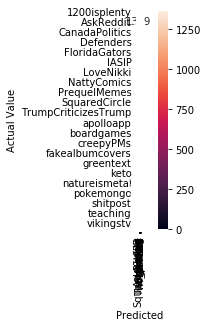

In [49]:
sns.heatmap(cm, annot=True, fmt='d', square=True)
plt.xlabel('Predicted')
plt.ylabel('Actual Value')
plt.show()

In [50]:
len(cm)

1236

<p>I half expected this, a huge confusion matrix and everything, but oh boy! I did glance at the actual confusion matrix, but the thing is huge so I reduced it down to displaying the length for presentation purposes. I'm afraid to look, but let's see the accuracy!</p>

In [51]:
sklearn.metrics.accuracy_score(y_test, y_pred)

0.11520555511717825

<p>11% Accuracy! That's an astronomical failure! We can do better than that. First, let's make our first variable change to be limited to a few subreddits.</p>

In [52]:
targetsubreddits = ["relationships", "todayilearned", "nba", "nfl"]

In [53]:
above50t = above50[above50.subreddit.isin(targetsubreddits)]

In [54]:
trainingdata, testingdata, y_train, y_test = train_test_split(above50t["body"], above50t["subreddit"], test_size = 1/5, random_state = 0)

In [55]:
trainingfit = vectorizer.fit_transform(trainingdata)
testingfit = vectorizer.transform(testingdata)
clf = MultinomialNB()
clf.fit(trainingfit, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [56]:
y_pred = clf.predict(testingfit)
cm = pd.crosstab(y_test, y_pred)

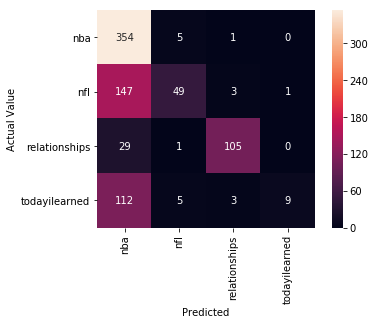

In [57]:
sns.heatmap(cm, annot=True, fmt='d', square=True)
plt.xlabel('Predicted')
plt.ylabel('Actual Value')
plt.show()

In [58]:
sklearn.metrics.accuracy_score(y_test, y_pred)

0.6274271844660194

In [59]:
y_train.value_counts()

nba              1453
nfl               819
todayilearned     524
relationships     496
Name: subreddit, dtype: int64

<p>Hmmm, Number of values seem to be creating a huge disparity in the results. I expected there to be confusion to be between NBA and nfl, but the fact that it is taking values from today I learned means something else is afoot. We did manage to reach 60% accuracy though. What happens if I cut out NBA though?</p>

In [60]:
targetsubreddits = ["relationships", "todayilearned", "nfl"]
above50t = above50[above50.subreddit.isin(targetsubreddits)]
trainingdata, testingdata, y_train, y_test = train_test_split(above50t["body"], above50t["subreddit"], test_size = 1/5, random_state = 0)
vectorizer = TfidfVectorizer(min_df=2)
trainingfit = vectorizer.fit_transform(trainingdata)
testingfit = vectorizer.transform(testingdata)

In [61]:
print(len(trainingdata))
print(len(testingdata))

1842
461


In [62]:
clf = MultinomialNB()
clf.fit(trainingfit, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [63]:
y_pred = clf.predict(testingfit)
cm = pd.crosstab(y_test, y_pred)

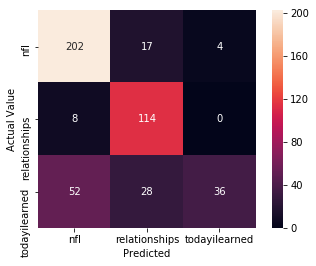

In [64]:
sns.heatmap(cm, annot=True, fmt='d', square=True)
plt.xlabel('Predicted')
plt.ylabel('Actual Value')
plt.show()

In [65]:
sklearn.metrics.accuracy_score(y_test, y_pred)

0.7635574837310195

<p>It seems like Today I learned uses a lot of language found in other subreddits. Not too surprising given the nature of that subreddit, but this may complicate things for the future. I will probably not use that one in my final classification challenge unless I figure out why it's happening this way. Accuracy went up about 14% when I removed NBA though. That's pretty good.</p>

In [66]:
targetsubreddits = ["relationships", "aww", "nfl", "nba", "PrequelMemes"]
above50t = above50[above50.subreddit.isin(targetsubreddits)]
trainingdata, testingdata, y_train, y_test = train_test_split(above50t["body"], above50t["subreddit"], test_size = 1/5)
vectorizer = TfidfVectorizer(min_df=2)
trainingfit = vectorizer.fit_transform(trainingdata)
testingfit = vectorizer.transform(testingdata)

In [67]:
print(len(trainingdata))
print(len(testingdata))

3164
791


In [68]:
clf = MultinomialNB()
clf.fit(trainingfit, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [69]:
y_pred = clf.predict(testingfit)
cm = pd.crosstab(y_test, y_pred)

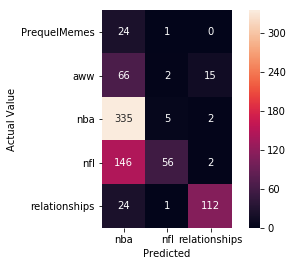

In [70]:
sns.heatmap(cm, annot=True, fmt='d', square=True)
plt.xlabel('Predicted')
plt.ylabel('Actual Value')
plt.show()

<p>Here, it seems the classifier cannot even predict r/PrequelMemes, and only identified one post from r/aww. I'm having trouble deciding what subreddits to pick because of this.</p>

In [71]:
sklearn.metrics.accuracy_score(y_test, y_pred)

0.6359039190897599

In [72]:
len(above50t[above50t.subreddit == "nba"]) / len(above50t)

0.4584070796460177

<p>62% accuracy despite misclassifying two whole categories. Given that this is greater than the percentage of nba posts in general, this isn't bad. I'll try Support Vectors since that seemed to be the best one on homework 3. We already have the data so we can just restart the machine learning part.</p>

In [73]:
vectorizer = TfidfVectorizer(min_df=2)
trainingfit = vectorizer.fit_transform(trainingdata)
testingfit = vectorizer.transform(testingdata)

In [74]:
svd = SVC(kernel='linear', C=1E5)
svd.fit(trainingfit, y_train)

SVC(C=100000.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [75]:
y_pred = svd.predict(testingfit)
cm = pd.crosstab(y_test, y_pred)
cm

col_0,PrequelMemes,aww,nba,nfl,relationships
subreddit,,,,,
PrequelMemes,8,2,7,5,3
aww,7,31,27,9,9
nba,3,30,261,39,9
nfl,1,14,70,117,2
relationships,1,7,10,7,112


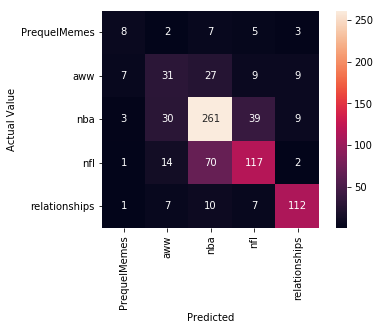

In [76]:
sns.heatmap(cm, annot=True, fmt='d', square=True)
plt.xlabel('Predicted')
plt.ylabel('Actual Value')
plt.show()

<p>Wow! That Worked So much better! r/Aww and r/PrequelMemes are still shafted a little, but we're definitely making progress! Also, I could probably have made the repeats above into a function, but I only realized that after writing the above. Accuracy please!</p>

In [77]:
sklearn.metrics.accuracy_score(y_test, y_pred)

0.6687737041719343

<p>5% Increase! Not bad, as it means I'm getting somewhere. I'll have to figure out what other features I can use to help identify the subreddit. Flair text might help slightly, since flairs are styled by subreddit if I remember correctly, but not every commentor has a flair. I honestly don't know if score would help, I'll learn how to combine different features with the textual ones for progress report 3.</p>

<a id="conc"></a><h2>Conclusion and Publishing Samples[<a href="#tablecontent">TOC</a>]</h2>
<p>I've still got quite a ways to go on this project. I don't have a solid list just yet, but I will more than likely try to include most of the subreddits used in the machine learning section. What I do know:
    <ul>
        <li>One sports-related subreddit will be definitely used, since sports are a major topic.</li>
        <li>relationships will stay since it seems to be easy to work with.</li>
        <li>I will try to use PrequelMemes since I like that subreddit.</li>
        <li>I might not use AskReddit, it has a disporportiante amount of data, and that subreddit can be used to discuss almost anything, so it might prove to be one of the most difficult subreddits to classify correctly.</li>
        <li>I'll try to keep aww since it does present some challenge, but if I remove it, I'll try another animal related subreddit.</li>
        <li>I will use subreddits with similar comment counts to the ones above to keep the data counts as similar as possible.</li>
    </ul>
<p>I suppose I'll publish some samples. I'll publish them in both json andp csv format. The json to keep it in the original format for programming purposes, and the csv for those who just want to look through it using excel or viewing on github. Since I haven't solidified the list, I'll keep to just the above50 frame for now. In Phase 3, I'll have a solidified list for sure.</p>
<p>As for machine learning, I'll have to figure out a better feature approach to identifying the subreddits. Just the text by itself is not enough in a sizable amount of cases. As I suspected, the comments between some subreddits share some common vocabulary choices. If I could somehow reach 90% accuracy, that would be nice.</p>

In [80]:
sampleframe = above50.sample(30000)

In [100]:
sampleframe.to_json("../data_samples/30000Above50Samples.json", orient="records")

In [96]:
sampleframe.head()

,author,author_cakeday,author_flair_css_class,author_flair_text,body,can_gild,controversiality,distinguished,gilded,id,is_submitter,link_id,parent_id,permalink,score,stickied,subreddit,subreddit_id,subreddit_type
465176,lhubbard0,0.0,Pacers2,[IND] Victor Oladipo,ASS+,True,0,none,0,drjz5t6,False,t3_7l6hb4,t1_drjy46g,/r/nba/comments/7l6hb4/clippers_danilo_gallina...,105,False,nba,t5_2qo4s,public
2125807,JiveTurkey1000,0.0,none,none,Somehow the McPoyles are worse off after the g...,True,0,none,0,drl1h08,False,t3_7l9nkm,t1_drl13ja,/r/AskReddit/comments/7l9nkm/what_tv_series_in...,81,False,AskReddit,t5_2qh1i,public
2628295,imnotarobot1010,0.0,none,none,"There's a book called ""Far from the Tree"" (I t...",True,0,none,0,drld36k,False,t3_7lbbku,t3_7lbbku,/r/relationships/comments/7lbbku/my_17m_sister...,140,False,relationships,t5_2qjvn,public
662751,Granny__Danger,0.0,Timberwolves5,Timberwolves,Do you think their net rating would be better ...,True,0,none,0,drk3qja,False,t3_7l5pzm,t1_drjqtsy,/r/nba/comments/7l5pzm/anthony_forgotten_davis...,52,False,nba,t5_2qo4s,public
1589501,_RarkGrames_,0.0,none,none,Maisie Williams.,True,0,none,0,drkp52r,False,t3_7l9ycr,t3_7l9ycr,/r/AskReddit/comments/7l9ycr/what_hot_celebrit...,62,False,AskReddit,t5_2qh1i,public


In [97]:
jsonframe = pd.read_json("../data_samples/30000Above50Samples.json")

In [98]:
jsonframe.head()

,author,author_cakeday,author_flair_css_class,author_flair_text,body,can_gild,controversiality,distinguished,gilded,id,is_submitter,link_id,parent_id,permalink,score,stickied,subreddit,subreddit_id,subreddit_type
0,lhubbard0,0,Pacers2,[IND] Victor Oladipo,ASS+,True,0,none,0,drjz5t6,False,t3_7l6hb4,t1_drjy46g,/r/nba/comments/7l6hb4/clippers_danilo_gallina...,105,False,nba,t5_2qo4s,public
1,JiveTurkey1000,0,none,none,Somehow the McPoyles are worse off after the g...,True,0,none,0,drl1h08,False,t3_7l9nkm,t1_drl13ja,/r/AskReddit/comments/7l9nkm/what_tv_series_in...,81,False,AskReddit,t5_2qh1i,public
2,imnotarobot1010,0,none,none,"There's a book called ""Far from the Tree"" (I t...",True,0,none,0,drld36k,False,t3_7lbbku,t3_7lbbku,/r/relationships/comments/7lbbku/my_17m_sister...,140,False,relationships,t5_2qjvn,public
3,Granny__Danger,0,Timberwolves5,Timberwolves,Do you think their net rating would be better ...,True,0,none,0,drk3qja,False,t3_7l5pzm,t1_drjqtsy,/r/nba/comments/7l5pzm/anthony_forgotten_davis...,52,False,nba,t5_2qo4s,public
4,_RarkGrames_,0,none,none,Maisie Williams.,True,0,none,0,drkp52r,False,t3_7l9ycr,t3_7l9ycr,/r/AskReddit/comments/7l9ycr/what_hot_celebrit...,62,False,AskReddit,t5_2qh1i,public


<p>The index is not preserved (not that it really matters, it's probably better this way), but otherwise, our data is saved as a json object. I will also publish a csv for those who just to peruse the data with a spreadsheet viewer. I'll also reuse the throwaway frame to save memory.</p>

In [105]:
sampleframe.to_csv("../data_samples/30000Above50Samples.csv", index=False)

In [106]:
jsonframe = pd.read_csv("../data_samples/30000Above50Samples.csv")

In [107]:
jsonframe.head()

,author,author_cakeday,author_flair_css_class,author_flair_text,body,can_gild,controversiality,distinguished,gilded,id,is_submitter,link_id,parent_id,permalink,score,stickied,subreddit,subreddit_id,subreddit_type
0,lhubbard0,0.0,Pacers2,[IND] Victor Oladipo,ASS+,True,0,none,0,drjz5t6,False,t3_7l6hb4,t1_drjy46g,/r/nba/comments/7l6hb4/clippers_danilo_gallina...,105,False,nba,t5_2qo4s,public
1,JiveTurkey1000,0.0,none,none,Somehow the McPoyles are worse off after the g...,True,0,none,0,drl1h08,False,t3_7l9nkm,t1_drl13ja,/r/AskReddit/comments/7l9nkm/what_tv_series_in...,81,False,AskReddit,t5_2qh1i,public
2,imnotarobot1010,0.0,none,none,"There's a book called ""Far from the Tree"" (I t...",True,0,none,0,drld36k,False,t3_7lbbku,t3_7lbbku,/r/relationships/comments/7lbbku/my_17m_sister...,140,False,relationships,t5_2qjvn,public
3,Granny__Danger,0.0,Timberwolves5,Timberwolves,Do you think their net rating would be better ...,True,0,none,0,drk3qja,False,t3_7l5pzm,t1_drjqtsy,/r/nba/comments/7l5pzm/anthony_forgotten_davis...,52,False,nba,t5_2qo4s,public
4,_RarkGrames_,0.0,none,none,Maisie Williams.,True,0,none,0,drkp52r,False,t3_7l9ycr,t3_7l9ycr,/r/AskReddit/comments/7l9ycr/what_hot_celebrit...,62,False,AskReddit,t5_2qh1i,public


<p>I'm not publishing it to be read by csv, but loading it back in was the best way to quickly tell if it was done properly. Well, that concludes the publishing section, and the phase notebook in general. Hope the progress I've made is to your liking!</p>